In [1]:
from config import setup, import_and_display_fnc
setup()

# More quadrature by expansion (QBX) examples for the Laplace equation: fun with screw dislocations

## Antiplane shear

A basic result in linear elastic earthquake modeling is the representation of displacement from slip on an infinitely long strike-slip fault. Because the fault is infinitely long, all displacements is fault parallel. Suppose we're looking at a cross-section in the $x,y$ plane with all displacement occuring in the $z$ direction. Then the displacement vector is $\mathbf{u} = (0, 0, u_z)$. And the strain state is:
\begin{equation}
\boldsymbol{\varepsilon} = \begin{bmatrix}
0 & 0 & \epsilon_{13} \\
0 & 0 & \epsilon_{23}\\
 \epsilon_{13}    &    \epsilon_{23}      & 0\end{bmatrix}
\end{equation}

This special state is called "antiplane shear". We can simplify the equations of linear elasticity to be in terms of a vector strain, $\epsilon_z = (\epsilon_{xz}, \epsilon_{yz})$ and vector stress, $\sigma_z = (2\mu\epsilon_{xz}, 2\mu\epsilon_{yz})$. Combined with Newtons law, we get the result that $u_z$ is a solution to the Laplace equation:

\begin{equation}
\nabla^2 u_z = 0
\end{equation}

As a result, we can describe the elastic behavior of infinitely long strike-slip faults (aka a "screw dislocation") in terms of solutions to the Laplace equation.

Below, we're going to use QBX to compute the displacements and stresses resulting from slip on infinitely long strike-slip faults with fun shapes. In particular, the "double layer" integral we computed in part 1 will compute displacement in the volume from the input slip on the fault. We'll also introduce the "hypersingular" integral to calculate stresses from slip.

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

## Barycentric Lagrange interpolation

When we compute a boundary integral, there are two sources of error: the surface approximation error and the quadrature error. We've been focusing so far on the quadrature error because it can be reduced dramatically with better algorithms, especially in the singular or near-singular case. The surface approximation error is handled simply through using a higher resolution approximation to the surface -- for example, represent a circle with 100 points instead of 50. However, below, it will be nice to be able to hold the surface approximation error constant while reducing the quadrature error to zero. But, in the integration techniques we have been using, the quadrature error and the surface error are inextricably linked. When we increase from using 50 to 100 points to integrate a function over a circle, we have been improving both the surface approximation and also using a more accurate quadrature rule.

To separate the two components, we'll interpolate points from a low order surface approximation in order to calculate the locations of quadrature points for a higher order integral approximation. To make the difference more concrete... Before, we would calculate new point locations for a circle by calculating $(cos \theta, sin \theta)$. Now, we will calculate the new point from a polynomial interpolation of the $n$ existing points $\sum_{i}^n c_i p_i(x)$. In some sense, this is also more realistic. In a real-world application, we normally have a data-derived surface representation that we can't improve. On the other hand, even in that real world setting, we *can* add more quadrature points by interpolating on that surface. But adding more quadrature points won't make the surface itself any more accurate.

To do this, it's going to be helpful to have some functions for polynomial interpolation! We'll use the `scipy.interpolate.BarycentricInterpolator` implementation of [barycentric Lagrange interpolation](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf){cite:p}`Berrut2004`. I strongly recommend that paper if you've never run into barycentric Lagrange interpolation before!

Since we're going to be integrating and interpolating functions on a finite interval, we'll use a Gaussian quadrature rule for doing the quadrature. As a result, we will be interpolating at the Gauss-Legendre points.

In [3]:
import_and_display_fnc('common', 'gauss_rule')

def gauss_rule(n):
    """
    The n-point gauss quadrature rule on [-1, 1].
    Returns tuple of (points, weights)
    """
    k = np.arange(1.0, n)
    a_band = np.zeros((2, n))
    a_band[1, 0 : (n - 1)] = k / np.sqrt(4 * k * k - 1)  # noqa: E203
    x, V = scipy.linalg.eig_banded(a_band, lower=True)
    w = 2 * np.real(np.power(V[0, :], 2))
    return x, w

Below is a little check to make sure our interpolation snippet is working correctly. We interpolate $sin(5x)$ (plotted with a solid black line) on a grid of 7 points (blue dots) and plot the resulting approximate function (red dashes line). This isn't a rigorous check, but it is working! Convergence is very fast if we increase the interpolation order, but I've left out a demonstration of that.

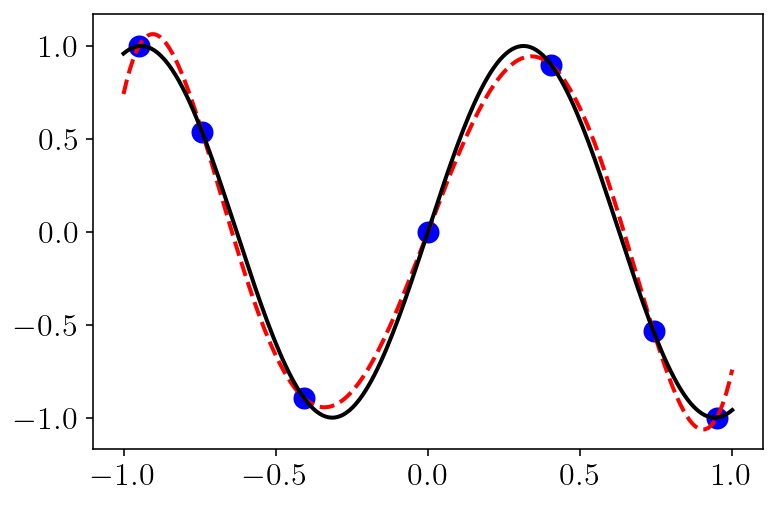

In [4]:
import scipy.interpolate

# First, form the interpolating polynomial
qx, qw = gauss_rule(7)
fqx = np.sin(5 * qx)
I = scipy.interpolate.BarycentricInterpolator(qx, fqx)

# Then, evaluate the polynomial at a bunch of points for plotting.
xs = np.linspace(-1, 1, 200)
v = I(xs)

plt.plot(qx, fqx, "bo", markersize=10)
plt.plot(xs, v, "r--")
plt.plot(xs, np.sin(5 * xs), "k-")
plt.show()

Let's move this into a couple helper functions for interpolating functions and surfaces.

In [5]:
import_and_display_fnc('common', 'interp_fnc')
import_and_display_fnc('common', 'interp_surface')

def interp_fnc(f, in_xhat, out_xhat):
    """
    Interpolate the function f(in_xhat) at the values f(out_xhat).

    `f`: An array consisting of f(in_xhat[i])
    `in_xhat`: The function inputs for which values are known already.
    `out_xhat`: The function inputs for which values are desired.

    Note that the in_xhat ordering is randomly permuted. This is a simple trick
    to improve numerical stability. A PR has been merged to scipy to implement
    this permutation within scipy.interpolate.BarycentricInterpolator but the new
    functionality has not yet been released.
    """
    permutation = np.random.permutation(in_xhat.shape[0])
    permuted_in_xhat = in_xhat[permutation]
    C = (np.max(permuted_in_xhat) - np.min(permuted_in_xhat)) / 4.0
    Cinv = 1.0 / C
    I = scipy.interpolate.BarycentricInterpolator(
        Cinv * permuted_in_xhat, f[permutation]
    )
    return I(Cinv * out_xhat)

def interp_surface(in_surf, out_quad_pts, out_quad_wts):
    """
    Interpolate each component of a surface: the pts, normals and jacobians
    """
    return Surface(
        out_quad_pts,
        out_quad_wts,
        interp_fnc(in_surf.pts, in_surf.quad_pts, out_quad_pts),
        interp_fnc(in_surf.normals, in_surf.quad_pts, out_quad_pts),
        interp_fnc(in_surf.jacobians, in_surf.quad_pts, out_quad_pts),
    )

## Hypersingular stress integrals

The second missing piece is a set of tools for computing stresses in the volume given an input fault slip. Continuing in the antiplane strain setting, what we want is to compute the gradient of displacement times the shear modulus.

\begin{equation}
(\sigma_{xz}, \sigma_{yz}) = (\mu \frac{\partial \phi}{\partial x}, \mu \frac{\partial \phi}{\partial y})
\end{equation}

To simplify things a bit here, I'm going to just compute the first compute $\sigma_{xz}$. This is equivalent to computing a traction with the normal vector equal to $(1, 0)$.

The hypersingular integral will computes $\sigma_{xz}$ for us given the source slip distribution. Since, we already built all the components of a QBX algorithm for the double layer case, we can now just write the naive integrator for a new kernel and everything works perfectly. In the cell below, I've implemented a naive integrator for the hypersingular integral.

```{margin}
As a reminder, By "naive integrator", I just mean the non-QBX integration function that would be the equivalent of the `double_layer_matrix` function from the previous section.
```

Why is this kernel called "hypersingular"? Because the kernel behaves like $O(\frac{1}{r^2})$ in 2D. This makes the integral especially difficult for many traditional integration methods. As you'll see below, this is not a barrier for QBX and we are able to calculate the integral extremely accurately even right on the surface.

```{note}
A quick summary of the common types of singular integrand behavior:
- **Weakly singular**: the integrand behaves like $O(log(r))$ in 2D. When we integrate a weakly singular integral over a surface, the integral is well-defined in the normal sense.
- **Strongly singular**: The double layer potential is strongly singular. The integrand behaves like $O(\frac{1}{r})$ in 2D. When we integrate a strongly singular integral over a surface, the integral must be defined in the Cauchy principal value sense. Otherwise, the integral is divergent (more or less equal to infinity). However, when the integral is computed as an interior limit, the value is well defined because no integral along the limiting path is ever actually singular.
- **Hypersingular**: The integrand behaves like $O(\frac{1}{r^2})$. The integral is so divergent that it's not even well-defined in the Cauchy principal value sense. Like strongly singular integrals, computing as an interior limit works out well.
```

In [6]:
import_and_display_fnc('common', 'hypersingular_matrix')

def hypersingular_matrix(source, obs_pts):
    dx = obs_pts[:, 0, None] - source.pts[None, :, 0]
    dy = obs_pts[:, 1, None] - source.pts[None, :, 1]
    r2 = dx ** 2 + dy ** 2

    A = 2 * (dx * source.normals[None, :, 0] + dy * source.normals[None, :, 1]) / r2
    C = 1.0 / (2 * np.pi * r2)
    out = np.empty((obs_pts.shape[0], 2, source.n_pts))

    # The definition of the hypersingular kernel.
    # unscaled sigma_xz component
    out[:, 0, :] = source.normals[None, :, 0] - A * dx
    # unscaled sigma_xz component
    out[:, 1, :] = source.normals[None, :, 1] - A * dy

    # multiply by the scaling factor, jacobian and quadrature weights
    return out * (C * (source.jacobians * source.quad_wts[None, :]))[:, None, :]

```{margin}
By leaving out the shear modulus, I'm implicitly assuming that $\mu = 1$. You can just imagine that we're solving a nondimensionalized version of the problem. This is quite common because scaling the displacement and stress to lie in a similar range of values can improve the numerical conditioning of some problems.
```

## Symbolic surfaces

For testing purposes, it's nice to have some tools for creating a range of interesting surface. Here, I'll put together a `symbolic_surface` function that allows defining a surface via a symbolic, parameterized form. Then, the discretized points, normals and jacobians are automatically computed.

In [7]:
import_and_display_fnc('common', 'discretize_symbolic_surface')
import_and_display_fnc('common', 'symbolic_eval')

def discretize_symbolic_surface(quad_pts, quad_wts, t, x, y):
    """
    Given a sympy parameteric expression for the x and y coordinates of a surface, we construct the points and normals and jacobians of that surface.
    `quad_pts`: A 1D array of the quadrature points in the domain [-1, 1].
    `quad_wts`: The weights of the quadrature rule.
    `t`: The parameter of the `x` and `y` expression. Expected to vary in [-1, 1]
    `x` and `y`: The parametric definition of the surface.
    """

    # Both the normal and jacobian will depend on the surface derivatives
    dxdt = sp.diff(x, t)
    dydt = sp.diff(y, t)

    jacobian = sp.simplify(sp.sqrt(dxdt ** 2 + dydt ** 2))

    # The normal vector is the normalized derivative vector.
    nx = -dydt / jacobian
    ny = dxdt / jacobian

    # At this point we have the points and normals and jacobians.  But they are
    # all still symbolic! So, we need to evaluate the expressions at the
    # specified quadrature points.
    surf_vals = [symbolic_eval(t, quad_pts, v) for v in [x, y, nx, ny, jacobian]]

    # And create the surface object.
    pts = np.hstack((surf_vals[0][:, None], surf_vals[1][:, None]))
    normals = np.hstack((surf_vals[2][:, None], surf_vals[3][:, None]))
    jacobians = surf_vals[4]

    return Surface(quad_pts, quad_wts, pts, normals, jacobians)

def symbolic_eval(t, tvals, e):
    result = sp.lambdify(t, e, "numpy")(tvals)
    if isinstance(result, float) or isinstance(result, int):
        result = np.full_like(tvals, result)
    return result

Let's try this out with a simple curve:
\begin{align}
x &= t\\
y &= \cos(t)
\end{align}
Below, I will call our `discretize_symbolic_surface` function and then plot the surface along with the normal vectors. The normal vectors will be colored to show the determinant of the Jacobian. We can see that the Jacobian is slightly larger at the ends of the surface than the middle.

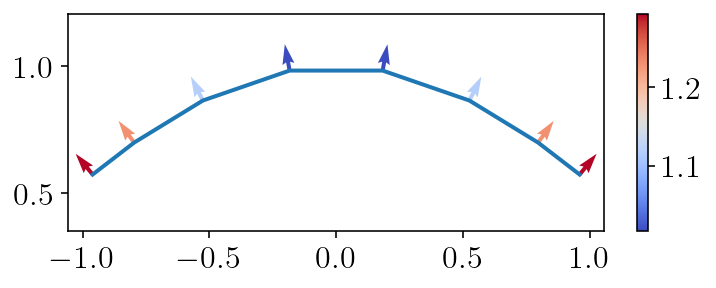

In [8]:
import sympy as sp
plt.figure(figsize=(6, 2))
qx, qw = gauss_rule(8)
sp_t = sp.var('t')

# The definition of the parameterized surface.
x = sp_t
y = sp.cos(sp_t)

# Convert into a discretized surface.
S = discretize_symbolic_surface(qx, qw, sp_t, x, y)

plt.plot(S.pts[:,0], S.pts[:,1])
plt.quiver(S.pts[:,0], S.pts[:,1], S.normals[:,0], S.normals[:,1], S.jacobians, scale=20, cmap='coolwarm')
plt.axis('equal')
plt.colorbar()
plt.show()

## General purpose interior evaluation

Next, I'm going to combine the ideas of the last section into a single function that will calculate a surface integral for an arbitrary set of observation points. To be precise, we will compute:

\begin{equation}
f(x) = \int_{S} K(x, y) \phi(y)
\end{equation}

where $x$ corresponds to `obs_pts`, $S$ corresponds to `surface`, $K(x,y)$ corresponds to `kernel`, and $\phi(y)$ corresponds to `density`.

Finally, I'll write a pretty big function that is going to produce nice figures for comparing QBX against a naive computation. The function is written to be independent of the surface and kernel function. It also accepts QBX parameters. As a reminder, `offset_mult` is a multiplier for how far off the surface the QBX expansion centers are placed. `kappa` is the upsampling rate in case we want to use a higher order quadrature for computing QBX coefficients than for representing the surface. And `qbx_p` is the order of the power series expansion. Please look through the function! Very little is new compared to the previous section. We're just applying the tools we've already built.

In [9]:
from common import double_layer_matrix, pts_grid, qbx_setup, interior_matrix

In [10]:
def qbx_example(
    kernel, surface_fnc, n, offset_mult, kappa, qbx_p, vmin=None, vmax=None
):
    def slip_fnc(xhat):
        # This must be zero at the endpoints for potential gradient to be finite.
        return np.cos(xhat * np.pi) + 1.0

    surface_low = surface_fnc(n)
    slip_low = slip_fnc(surface_low.quad_pts)

    nobs = 400
    zoomx = [-1.5, 1.5]
    zoomy = [-1.5, 1.5]
    xs = np.linspace(*zoomx, nobs)
    ys = np.linspace(*zoomy, nobs)
    obs_pts = pts_grid(xs, ys)

    low_vals = (
        kernel(surface_low, obs_pts)
        .dot(slip_low)[:, 0]
        .reshape((nobs, nobs))
    )

    quad_rule_high = gauss_rule(2000)
    surface_high = interp_surface(surface_low, *quad_rule_high)
    slip_high = interp_fnc(slip_low, surface_low.quad_pts, quad_rule_high[0])
    high_vals = (
        kernel(surface_high, obs_pts)
        .dot(slip_high)[:, 0]
        .reshape((nobs, nobs))
    )

    expansions = qbx_setup(surface_low, mult=offset_mult, p=qbx_p)

    qbx_quad_pts, qbx_quad_wts = gauss_rule(n * kappa)
    surface_qbx = interp_surface(surface_low, qbx_quad_pts, qbx_quad_wts)
    slip_qbx = interp_fnc(slip_low, surface_low.quad_pts, qbx_quad_pts)

    plt.figure()
    plt.plot(surface_qbx.pts[:,0], surface_qbx.pts[:,1], "k-")
    plt.plot(expansions.pts[:,0], expansions.pts[:,1], "r.")
    plt.show()

    qbx_vals = interior_matrix(
        kernel,
        surface_qbx,
        obs_pts,
        expansions
    ).dot(slip_qbx)[:,0].reshape((nobs, nobs))

    if vmin is None:
        vmin = -1.0
    if vmax is None:
        vmax = 1.0
    levels = np.linspace(vmin, vmax, 16)

    obsx = obs_pts[:,0].reshape((nobs, nobs))
    obsy = obs_pts[:,1].reshape((nobs, nobs))

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 3, 1)
    plt.title("Naive solution")
    cntf = plt.contourf(obsx, obsy, low_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        low_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(surface_high.pts[:,0], surface_high.pts[:,1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 2)
    plt.title('"Accurate" solution')
    cntf = plt.contourf(obsx, obsy, high_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        high_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    plt.plot(surface_high.pts[:,0], surface_high.pts[:,1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 3)
    plt.title("Naive error")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        logerror = np.log10(np.abs(low_vals - high_vals))
    logerror[np.isinf(logerror)] = -12.0
    cntf = plt.contourf(
        obsx, obsy, logerror, levels=np.linspace(-12, 0, 13), extend="both"
    )
    plt.contour(
        obsx,
        obsy,
        logerror,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=np.linspace(-12, 0, 13),
        extend="both",
    )
    cb = plt.colorbar(cntf)
    cb.set_label(r"$\log_{10}(|\hat{u} - \hat{u}_{\textrm{naive}}|)$", fontsize=14)
    plt.plot(surface_high.pts[:,0], surface_high.pts[:,1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()

    plt.subplot(2, 3, 4)
    plt.title("QBX solution")
    cntf = plt.contourf(obsx, obsy, qbx_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        qbx_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(surface_high.pts[:,0], surface_high.pts[:,1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 5)
    plt.title('"Accurate" solution')
    cntf = plt.contourf(obsx, obsy, high_vals, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        high_vals,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    plt.plot(surface_high.pts[:,0], surface_high.pts[:,1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 6)
    plt.title("QBX error")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        logerror = np.log10(np.abs(qbx_vals - high_vals))
    logerror[np.isinf(logerror)] = -12.0
    cntf = plt.contourf(
        obsx, obsy, logerror, levels=np.linspace(-12, 0, 13), extend="both"
    )
    plt.contour(
        obsx,
        obsy,
        logerror,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=np.linspace(-12, 0, 13),
        extend="both",
    )
    cb = plt.colorbar(cntf)
    cb.set_label(r"$\log_{10}(|\hat{u} - \hat{u}_{\textrm{QBX}}|)$", fontsize=14)
    plt.plot(surface_high.pts[:,0], surface_high.pts[:,1], "k-", linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()
    plt.show()

## Displacement from a line source

For the remainder of this part, we'll compute displacements and stresses for a three simple geometries of increasing difficulty.

For each plot, there will be a geometry summary that's just a black line showing the location of the "fault" and red dots showing the location of the QBX expansions.

Then, we'll plot three solutions: the naive solution, a high accuracy naive solution (from 2000 points) and a QBX solution. We'll also plot the $\log_{10}$ error for both the naive and QBX solutions.

In [ ]:
def line(n):
    qx, qw = gauss_rule(n)
    sp_t = sp.var('t')
    return discretize_symbolic_surface(qx, qw, sp_t, sp_t, 0 * sp_t)

qbx_example(
    double_layer_matrix, surface_fnc=line, n=16, offset_mult=8, kappa=3, qbx_p=15
)

## Stress from a line source

In [ ]:
qbx_example(
    hypersingular_matrix, surface_fnc=line, n=32, offset_mult=8, kappa=5, qbx_p=15
)

## Displacement from an arc source

In [ ]:
def arc(n):
    qx, qw = gauss_rule(n)
    sp_t = sp.var('t')
    theta = 0.5 * sp_t * sp.pi + 0.5 * sp.pi
    x = sp.cos(theta)
    y = sp.sin(theta) - 0.5
    return discretize_symbolic_surface(qx, qw, sp_t, x, y)

qbx_example(
    double_layer_matrix, surface_fnc=arc, n=16, offset_mult=8, kappa=3, qbx_p=20
)

## Stress from an arc source

In [ ]:
qbx_example(
    hypersingular_matrix, surface_fnc=arc, n=32, offset_mult=8, kappa=5, qbx_p=20
)

## Displacement from a challenging wavy source

In [ ]:
def wavy(n):
    qx, qw = gauss_rule(n)

    sp_t = sp.var('t')
    x, y = sp_t, sp.sin((sp_t + 1) * 2 * sp.pi)

    return discretize_symbolic_surface(qx, qw, sp_t, x, y)

qbx_example(
    double_layer_matrix,
    surface_fnc=wavy,
    n=256,
    offset_mult=5.0,
    kappa=5,
    qbx_p=15,
)

## Stress from a challenging wavy source

In [ ]:
qbx_example(
    hypersingular_matrix, surface_fnc=wavy, n=256, offset_mult=5, kappa=5, qbx_p=15
)